<a href="https://colab.research.google.com/github/Nadeem786087/Luad-cancer-classifier/blob/main/Luad_cancer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HiSeqV2 to HiSeqV2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
filename = list(uploaded.keys())[0]  # Auto-detect uploaded file

# Read raw lines
with open(filename, 'r') as f:
    lines = f.readlines()

# First line = samples (skip "sample" word)
samples = lines[0].strip().split()[1:]

# Parse genes and expression values
genes = []
expression_data = []
for line in lines[1:]:
    if line.strip():  # Skip empty lines
        parts = line.strip().split()
        gene = parts[0]
        values = [float(v) for v in parts[1:]]
        genes.append(gene)
        expression_data.append(values)

# Create DataFrame (samples as rows, genes as columns)
df = pd.DataFrame(expression_data, index=genes, columns=samples).T
print(f"Loaded data: {df.shape[0]} samples, {df.shape[1]} genes")
df.head()

Loaded data: 576 samples, 20530 genes


,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-69-7978-01,9.9898,4.2598,0.4181,10.3657,11.1718,10.5897,12.2708,4.7670,0.0000,8.2023,...,1.8836,0.7420,6.2348,0.0000,9.4520,12.7565,8.2668,11.2400,6.1209,9.8977
TCGA-62-8399-01,10.4257,11.6239,0.0000,11.5489,11.0200,9.2843,12.1540,5.7125,0.4628,5.5819,...,0.4628,1.5316,4.4464,1.3294,9.5226,12.2100,8.5437,10.3491,8.6398,9.7315
TCGA-78-7539-01,9.6264,9.1362,1.1231,11.6692,10.4679,10.4649,12.6559,4.3943,0.3725,3.5365,...,2.9588,0.0000,6.0400,3.9201,9.2765,10.6498,6.1814,11.1659,6.0970,10.3540
TCGA-50-5931-11,8.6835,9.4824,0.8221,11.7341,11.6787,11.5412,11.9285,5.9466,0.8221,3.3528,...,0.0000,2.4876,6.3782,0.0000,8.6781,14.6956,9.7151,10.5910,9.5115,10.4914
TCGA-73-4658-01,9.2078,5.0288,0.0000,11.6209,11.3414,10.9376,12.0539,6.0942,0.0000,7.4156,...,0.0000,0.6557,6.3898,1.1048,9.2697,13.0036,8.9786,10.6777,8.4187,10.3142


In [ ]:
# TCGA barcode: positions 13-15 are sample type (01=tumor, 11=normal)
def get_label(sample_id):
    parts = sample_id.split('-')
    if len(parts) >= 4:
        code = parts[3][:2]
        return 1 if code == '01' else (0 if code == '11' else None)
    return None

labels = pd.Series([get_label(idx) for idx in df.index], index=df.index)
labels = labels.dropna()  # Remove any invalid
df = df.loc[labels.index]

print("Class distribution:")
print(labels.value_counts())

# Convert to numpy
X = df.values.astype(float)
y = labels.values

Class distribution:
1.0    515
0.0     59
Name: count, dtype: int64


In [ ]:
# Median Absolute Deviation (robust for genomics)
mad = np.median(np.abs(X - np.median(X, axis=0)), axis=0)
top_indices = np.argsort(mad)[::-1][:2000]  # Top 2000

X_selected = X[:, top_indices]
selected_genes = df.columns[top_indices]

print(f"Reduced to {X_selected.shape[1]} genes")

Reduced to 2000 genes


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (459, 2000), Test: (115, 2000)


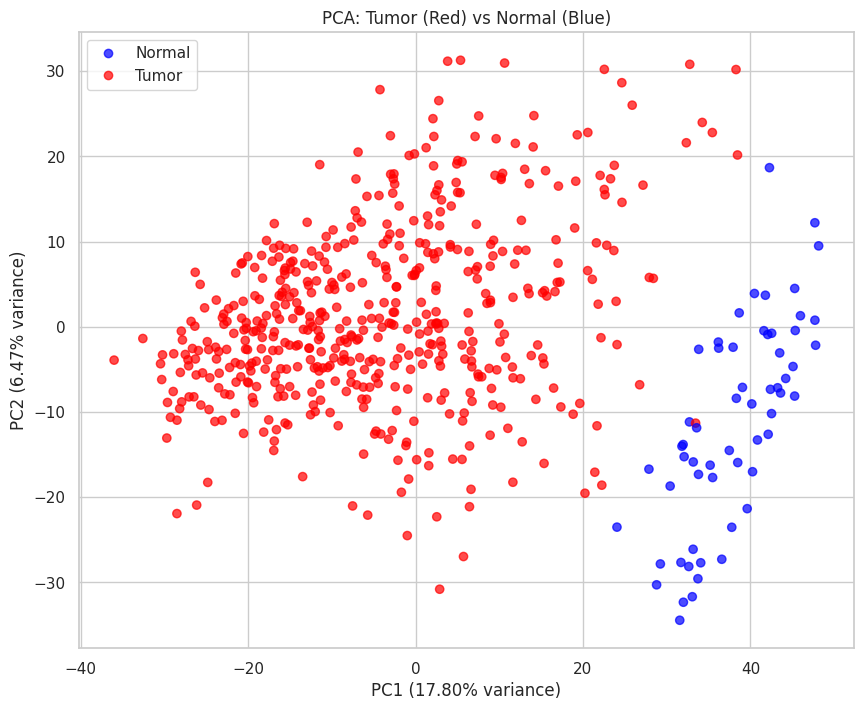

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: Tumor (Red) vs Normal (Blue)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Tumor'])
plt.show()

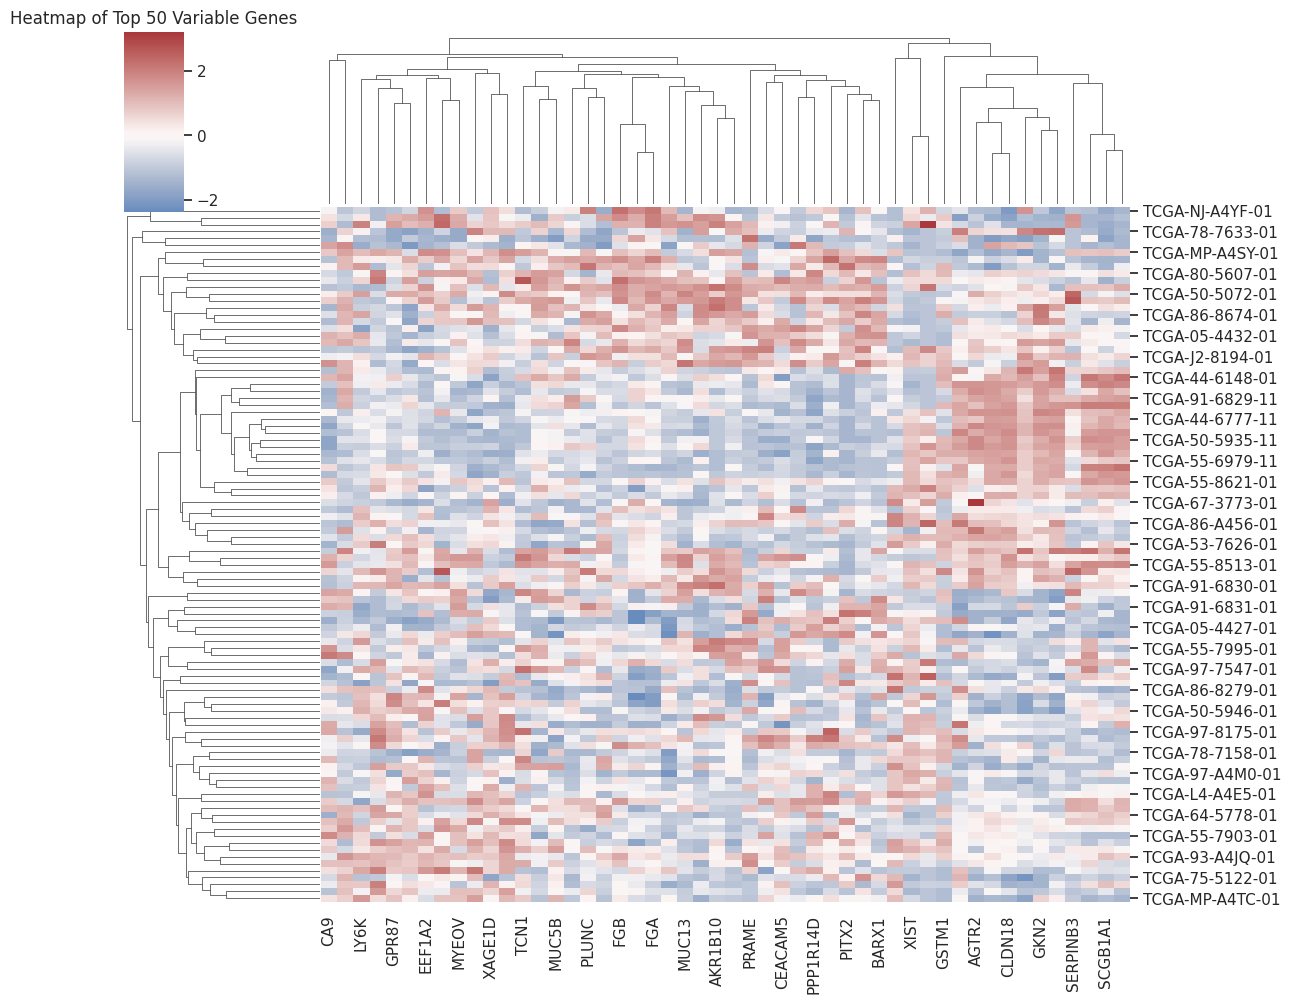

In [ ]:
top_50_data_for_heatmap = X_scaled[:, :50]
top_50_gene_names = selected_genes[:50]
sns.clustermap(
    pd.DataFrame(top_50_data_for_heatmap, index=df.index[:top_50_data_for_heatmap.shape[0]], columns=top_50_gene_names).sample(min(top_50_data_for_heatmap.shape[0], 100)),
    cmap='vlag', center=0, figsize=(12, 10), col_cluster=True, row_cluster=True
)
plt.title("Heatmap of Top 50 Variable Genes")
plt.show()

In [ ]:
# Random Forest Grid Search
rf_param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)
print("Best CV F1:", rf_grid.best_score_)

Best RF params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best CV F1: 0.9889545801469468


In [ ]:
models = {'Random Forest': best_rf, 'SVM': best_svm}

for name, model in models.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("F1-score:", f1_score(y_test, pred, average='weighted'))
    print(classification_report(y_test, pred, target_names=['Normal', 'Tumor']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


=== Random Forest ===
Accuracy: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
       Tumor       1.00      1.00      1.00       103

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

Confusion Matrix:
 [[ 12   0]
 [  0 103]]

=== SVM ===
Accuracy: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
       Tumor       1.00      1.00      1.00       103

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

Confusion Matrix:
 [[ 12   0]
 [  0 103]]


In [ ]:
# SVM Grid Search
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear'],
    'class_weight': ['balanced']
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
svm_grid.fit(X_train, y_train)

best_svm = svm_grid.best_estimator_
print("Best SVM params:", svm_grid.best_params_)
print("Best CV F1:", svm_grid.best_score_)

Best SVM params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best CV F1: 0.9978711783459715


In [17]:
models = {'Random Forest': best_rf, 'SVM': best_svm}

for name, model in models.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("F1-score:", f1_score(y_test, pred, average='weighted'))
    print(classification_report(y_test, pred, target_names=['Normal', 'Tumor']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


=== Random Forest ===
Accuracy: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
       Tumor       1.00      1.00      1.00       103

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

Confusion Matrix:
 [[ 12   0]
 [  0 103]]

=== SVM ===
Accuracy: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        12
       Tumor       1.00      1.00      1.00       103

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

Confusion Matrix:
 [[ 12   0]
 [  0 103]]


In [18]:
# Choose the better model (usually RF)
final_model = best_rf  # Change to best_svm if it performs better

joblib.dump(final_model, 'best_luad_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_genes.tolist(), 'selected_genes.pkl')

# Optional: Save to Drive
!cp best_luad_model.pkl /content/drive/MyDrive/
!cp scaler.pkl /content/drive/MyDrive/
!cp selected_genes.pkl /content/drive/MyDrive/

print("Model, scaler, and gene list saved! Use in FastAPI backend.")

cp: cannot create regular file '/content/drive/MyDrive/': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/': No such file or directory
Model, scaler, and gene list saved! Use in FastAPI backend.


In [19]:
from google.colab import files

files.download('best_luad_model.pkl')
files.download('scaler.pkl')
files.download('selected_genes.pkl')

print("All files downloaded! Save them safely for your FastAPI backend.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded! Save them safely for your FastAPI backend.


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!cp best_luad_model.pkl /content/drive/MyDrive/best_luad_model.pkl
!cp scaler.pkl /content/drive/MyDrive/scaler.pkl
!cp selected_genes.pkl /content/drive/MyDrive/selected_genes.pkl

print("Saved to Drive successfully!")

Saved to Drive successfully!


In [24]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

model = joblib.load('best_luad_model.pkl')
scaler = joblib.load('scaler.pkl')
selected_genes = joblib.load('selected_genes.pkl')  # List of str

In [25]:
def predict_uploaded(csv_path):
    df_new = pd.read_csv(csv_path, index_col=0)  # Or adjust parsing
    # Align to exact selected_genes (fill missing with median or 0)
    X_new = np.zeros((1, len(selected_genes)))
    for i, gene in enumerate(selected_genes):
        if gene in df_new.columns:
            X_new[0, i] = df_new[gene].iloc[0]
        else:
            X_new[0, i] = 0  # Or median from training

    X_scaled = scaler.transform(X_new)
    pred = model.predict(X_scaled)[0]
    prob = model.predict_proba(X_scaled)[0, 1]  # Tumor probability

    return "Tumor" if pred == 1 else "Normal", float(prob)

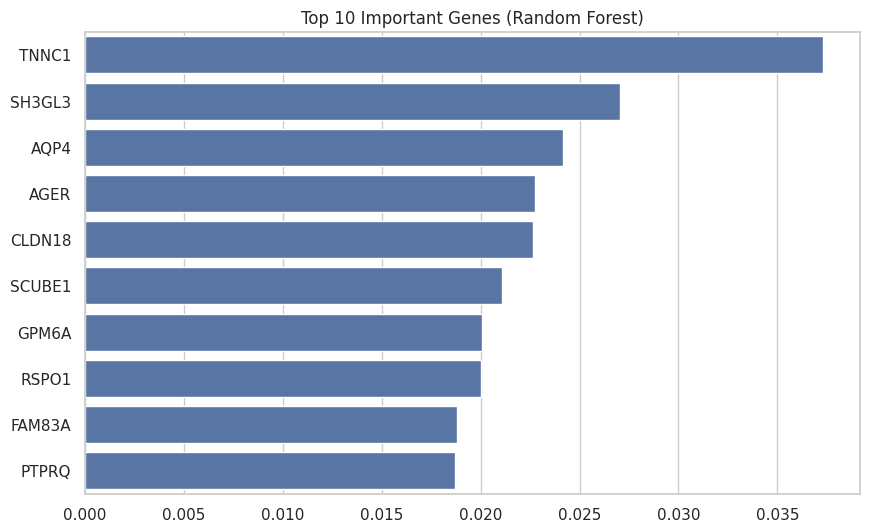

Top genes: [np.str_('TNNC1'), np.str_('SH3GL3'), np.str_('AQP4'), np.str_('AGER'), np.str_('CLDN18'), np.str_('SCUBE1'), np.str_('GPM6A'), np.str_('RSPO1'), np.str_('FAM83A'), np.str_('PTPRQ')]


In [27]:
importances = best_rf.feature_importances_
top_idx = np.argsort(importances)[::-1][:10]

top_genes = np.array(selected_genes)[top_idx]
top_scores = importances[top_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=top_scores, y=top_genes)
plt.title("Top 10 Important Genes (Random Forest)")
plt.show()

print("Top genes:", list(top_genes))

In [28]:
import joblib
import pandas as pd
import numpy as np

# Load genes (you have this file)
selected_genes = joblib.load('selected_genes.pkl')  # Run in same folder as .pkl

# Create fake tumor sample (high values ~10-12)
tumor_data = np.random.uniform(8, 12, len(selected_genes))

# Create fake normal sample (lower values ~4-8)
normal_data = np.random.uniform(4, 8, len(selected_genes))

# Save as DataFrames
tumor_df = pd.DataFrame([tumor_data], columns=selected_genes, index=['Demo_Tumor_Sample'])
normal_df = pd.DataFrame([normal_data], columns=selected_genes, index=['Demo_Normal_Sample'])

tumor_df.to_csv('demo_tumor.csv')
normal_df.to_csv('demo_normal.csv')

print("Demo files created! Prediction should be Tumor/Normal with high confidence.")

Demo files created! Prediction should be Tumor/Normal with high confidence.


In [30]:
from google.colab import files

# Real tumor demo
tumor_demo = df[y == 1].iloc[0:1][selected_genes]
tumor_demo.to_csv('demo_tumor.csv')
files.download('demo_tumor.csv')

# Real normal demo
normal_demo = df[y == 0].iloc[0:1][selected_genes]
normal_demo.to_csv('demo_normal.csv')
files.download('demo_normal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>